# Análise de Dados com Web Scrapper
Grupo: Guilherme Rameh & Henrique Martinelli

### Primeira Etapa:
 Importando as bibliotecas necessárias.

In [1]:
import scrapy
import json
import re
from scrapy.crawler import CrawlerProcess

from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
import time

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Markdown as md

### Segunda Etapa:
 Para preparar a página web para podermos obter os dados que queremos, usamos a biblioteca *Selenium*, que simula as ações de um usuário na página. Usamos desse recurso para carregar a página para que mostrasse diversos jogos (a página padrão pelo URL mostrava apenas 12 títulos).

In [5]:
# Prepara o driver que o selenium usa e acessa o site a partir do URL.
driver = webdriver.Chrome("env/Lib/site-packages/chromedriver.exe")
driver.get("https://www.promobit.com.br/promocoes/jogos-de-pc/s/")

# Prepara uma ação e executa, movendo até o botão de "load more", identificado pela sua classe css.
action = ActionChains(driver)
action.move_to_element(driver.find_element_by_css_selector(".css-1xhzu1x"))
action.perform()

# Identifica o botão e clica nele, novamente pela sua classe css.
load_more_button = driver.find_element_by_css_selector(".css-1xhzu1x")
load_more_button.click()

# Após um tempo para permitir a página de carregar, executa-se um script para descer um pouco, forçando o carregamento 
# de mais jogos.
time.sleep(3)
driver.execute_script("window.scrollTo(0, 5000)")
time.sleep(7)
driver.execute_script("window.scrollTo(0, 8000)")

# Salva a resposta web como um objeto Selector, da biblioteca Scrapy, que será usada para pegar as informações que queremos
selenium_response_text = driver.page_source
response = scrapy.Selector(text=selenium_response_text)

C:\Users\guilh\AppData\Local\Temp/ipykernel_17784/4037731520.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome("env/Lib/site-packages/chromedriver.exe")
C:\Users\guilh\AppData\Local\Temp/ipykernel_17784/4037731520.py:7: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  action.move_to_element(driver.find_element_by_css_selector(".css-1xhzu1x"))
C:\Users\guilh\AppData\Local\Temp/ipykernel_17784/4037731520.py:11: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  load_more_button = driver.find_element_by_css_selector(".css-1xhzu1x")


### Terceira Etapa:
Preparada a página, usaremos outra biblioteca para fazer o scrap da página. A biblioteca é o *Scrapy*. Essa etapa poderia ser feita pelo Selenium, mas como o grupo já tinha implementado um código com o Scrapy antes, foi mais fácil de entender e aplicar no Notebook.

In [6]:
# Cria uma lista onde todos os objetos de jogo serão salvos
games_lista = []

# Usa as variáveis chamadas _SELECTOR para salvar as classes CSS dos objetos que queremos encontrar.
# Também fazemos um for loop para passar por todos os jogos e salvar seu nome, preços, loja e há quanto tempo foi postado.
SET_SELECTOR = '.css-wauoyl'
for game in response.css(SET_SELECTOR):
    NAME_SELECTOR = '.css-10227v0 ::text'
    OLDPRICE_SELECTOR = '.css-124gmjl ::text'
    NEWPRICE_SELECTOR = '.css-1u0404w ::text'
    STORE_SELECTOR = '.css-1a7v2lf ::text'
    games_lista.append({
        'name': game.css(NAME_SELECTOR).extract(),
        'store': game.css(STORE_SELECTOR).extract(),
        'price': game.css(OLDPRICE_SELECTOR).extract(),
        'discounted price': game.css(NEWPRICE_SELECTOR).extract(),
        'time': game.css('.css-1oxwbh0 ::text').extract(),
    })
    
md(f'Número de jogos pegos pelo scrap: {len(games_lista)}')

# run_spider()

# with open("items.json") as file:
#     games_lista = json.load(file)

Número de jogos pegos pelo scrap: 276

### Quarta Etapa:
 Finalmente temos agora nossos dados. Para conseguir lidar com eles, é preciso primeiro limpar as strings, pois a grande maioria possui informações desnecessárias para nossa análise. São definidas as funções de limpeza, e dentro de um grande loop, os jogos são filtrados por disponibilidade, tempo de publicação (quanto tempo ofi postado no site aquela promoção, pois talvez ela não seja mais válida).

In [7]:
def cleanupTitle(full_title):
    if "Jogo" not in full_title:
        return full_title
    splitlist = re.split("Jogo | -", full_title)
    return splitlist[1]

def cleanupFullPrice(price_string):
    if price_string == "de graça!":
        return "0"
    else:
        splitlist = price_string.split("\xa0")
        price = splitlist[-1].replace(".","")
        return price.replace(",",".")

def cleanupFreeGame(price_string):
    if price_string == "de graça!":
        return "0"
    else:
        price = price_string.replace(".","")
        return price.replace(",",".")

In [8]:
games_by_store = {}
for item in games_lista:
    
    time = item['time'][0]
    if 'meses' in time or 'ano' in time or 'anos' in time:
        continue
        
    if item['discounted price'] == []:
        continue
        
    prices = {}
    full_title = item['name'][0]
    store = item['store'][0]
    discounted_price = item['discounted price'][0]
    
    game = cleanupTitle(full_title)
    discounted_price = cleanupFreeGame(discounted_price)
    
    if item['price'] != []:
        notclean_price = item['price'][0]
        full_price = cleanupFullPrice(notclean_price)
    else:
        full_price = cleanupFreeGame(item['discounted price'][0])
    
    prices = [full_price, discounted_price]
    
    if store not in games_by_store.keys():
        games_by_store[store] = []
    games_by_store[store].append({'game': game, 'prices': prices, 'time':time})

lenght = 0
for i in games_by_store:
    lenght += len(games_by_store[i])
    
md(f'Quantidade de jogos após filtragem: {lenght}')

Quantidade de jogos após filtragem: 250

### Quinta Etapa:
 Por fim, com os jogos filtrados, é possível fazermos uma análise dos dados obtidos. Decidimos por fazer, na maior parte, uma análise por loja, definindo a média de preços por jogo, média da porcentagem de desconto, e número de jogos, permitindo uma visão geral. Ainda por cima fazemos uma análise aprofundada sobre quais são os jogos com maior desconto, em porcentagem e em dinheiro, e ainda uma lista de jogos de graça para caso não queira gastar dinheiro, por exemplo.

> *Observe as duas células abaixo para ver os gráficos plotados (primeira) e os jogos análisados (segunda).

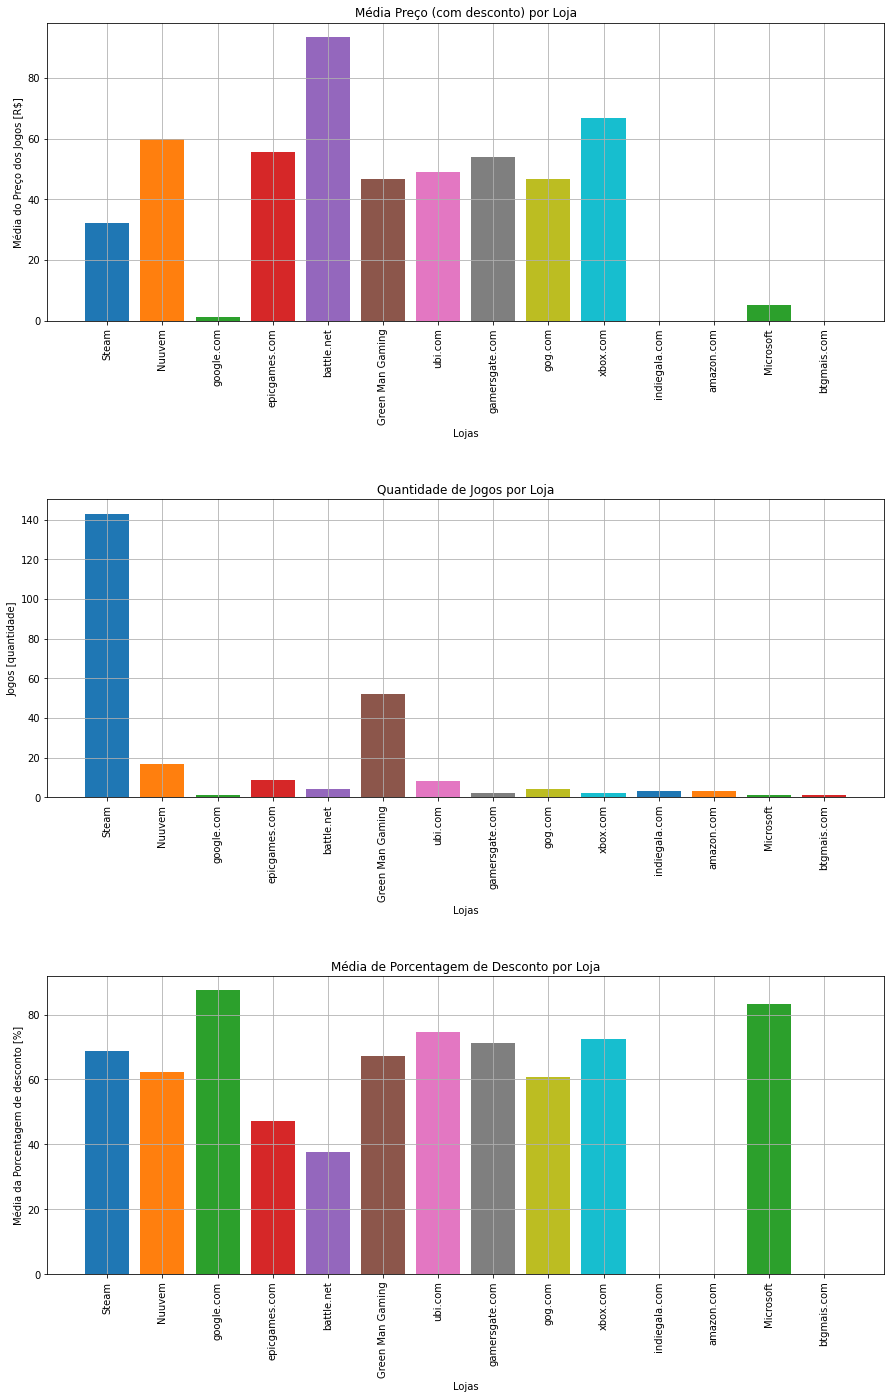

In [9]:
plt.figure(figsize=[15, 30])

best_deal_per = [[],[],[]]
dif = 0

best_deal_dinh = [{},""]
discount = 0

free_games = []

for store in games_by_store:
    num_games = len(games_by_store[store])
    all_prices = 0.0
    all_percentages = 0
    for games in games_by_store[store]:
        all_prices += float(games['prices'][1])
        
        price_full = float(games['prices'][0])
        discounted_price = float(games['prices'][1])
        if price_full == 0:
            percentage_discount = 0
        else:
            percentage_discount = 100-((discounted_price*100)/price_full)
    
        diferenca = price_full - discounted_price
        if diferenca > dif:
            dif = diferenca
            best_deal_dinh[0] = games
            best_deal_dinh[1] = store
            
        if price_full == 0:
            free_games.append([games, store])
            
        if percentage_discount >= discount:
            if percentage_discount == discount:
                best_deal_per[0].append(games)
                best_deal_per[1].append(store)
                best_deal_per[2].append(discount)
            else:
                discount = percentage_discount
                best_deal_per=([games], [store], [discount])

        all_percentages += percentage_discount
    
    mean_percentage = all_percentages/num_games
    mean_prices = all_prices/num_games        
    
    plt.subplot(4,1, 1)
    plt.title("Média Preço (com desconto) por Loja")
    plt.xlabel("Lojas")
    plt.ylabel("Média do Preço dos Jogos [R$]")
    plt.bar(store, mean_prices)
    plt.xticks(rotation = 'vertical')
    plt.grid(True)
    
    plt.subplot(4,1, 2)
    plt.title("Quantidade de Jogos por Loja")
    plt.xlabel("Lojas")
    plt.ylabel("Jogos [quantidade]")
    plt.bar(store, num_games)
    plt.xticks(rotation = 'vertical')
    plt.grid(True)
    
    plt.subplot(4,1, 3)
    plt.title("Média de Porcentagem de Desconto por Loja")
    plt.xlabel("Lojas")
    plt.ylabel("Média da Porcentagem de desconto [%]")
    plt.bar(store, mean_percentage)
    plt.xticks(rotation = 'vertical')
    plt.grid(True)
    
plt.subplots_adjust(left=0.125, bottom=0.1 , right=0.9 , top=0.9, wspace=0.2, hspace=0.6)

In [10]:
string_md = f""
string_md += ("### As melhores ofertas do mês:\n\n")
for i in range(len(best_deal_per[0])):
    string_md += (f'- Loja {best_deal_per[1][i]} com o jogo {best_deal_per[0][i]["game"]} com {best_deal_per[2][i]}% de desconto,mudando de R\${best_deal_per[0][i]["prices"][0]} para RS {best_deal_per[0][i]["prices"][1]}\n')
    
string_md += (f'\n### ECONOMIZE!')
string_md += (f'\nA Loja {best_deal_dinh[1]} está com uma promoção incrível! Comprando {best_deal_dinh[0]["game"]},\n\
voce economiza RS{dif}! De RS{best_deal_dinh[0]["prices"][0]} para RS{best_deal_dinh[0]["prices"][1]}\n') 

string_md += (f'\n### Aqui são alguns jogos de graça para você aproveitar!\n')
for game in free_games:
    string_md += (f'- Jogo {game[0]["game"]} na loja *{game[1]}*\n')
    
md(string_md)

### As melhores ofertas do mês:

- Loja Steam com o jogo DLC Train Simulator: Amtrak P42DC 50th Anniversary Collector’s Edition - PC com 100.0% de desconto,mudando de R\$37.99 para RS 0
- Loja ubi.com com o jogo Tom Clancys Splinter Cell Chaos Theory gratis com 100.0% de desconto,mudando de R\$29.90 para RS 0

### ECONOMIZE!
A Loja Steam está com uma promoção incrível! Comprando 100 Games Bundle,
voce economiza RS883.76! De RS1210.19 para RS326.43

### Aqui são alguns jogos de graça para você aproveitar!
- Jogo Multiplayer Halo Infinite - PC Steam na loja *Steam*
- Jogo TheHunter: Call of the Wild na loja *epicgames.com*
- Jogo Die Young: Prologue na loja *indiegala.com*
- Jogo Glorkian Warrior: The Trials Of Glork na loja *indiegala.com*
- Jogo Contract With The Devil na loja *indiegala.com*
- Jogo Rogue Heroes: Ruins of Tasos na loja *amazon.com*
- Jogo Control Ultimate Edition na loja *amazon.com*
- Jogo Dragon Age 3: Inquisition na loja *amazon.com*
- Jogo Tom Clancy’s Rainbow Six Siege Deluxe Edition na loja *btgmais.com*
